In [1]:
import numpy as np 
import pandas as pd 
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.svm import SVR
import json
from src.metric_participants import ComputeMetrics
from pandasql import sqldf
from typing import Tuple, Dict, List
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import sys
from datetime import datetime

makeQuery = lambda q: sqldf(q, globals())

In [2]:
with open('./data/data_files/train_validation_split_10.json', 'r') as f: 
    cvSplit = json.load(f)

In [3]:
# load cleaned sales data
salesTrain = pd.read_csv('./data/data_files/sales_train_splitted.csv', index_col=0)
salesTrain.head()

,month,region,brand,sales
0,2020-01,region_0,brand_1,0.00
1,2020-01,region_0,brand_2,0.00
2,2020-01,region_0,brand_3,65007.49
3,2020-01,region_0,brand_12_market,509023.69
4,2020-01,region_0,brand_3_market,940469.05


In [4]:
# split by brand and transform time data to columns
brands = ['brand_1', 'brand_2']
months = set(salesTrain['month'].values.tolist())
regions = set(salesTrain['region'].values.tolist())

transformedData = {}
for brand in brands: 
    brandData = {}
    for month in months: 
        query = """
        SELECT region, sales
        FROM salesTrain
        WHERE brand = '{brand}'
        AND month = '{month}'
        """.format(brand=brand, month=month)
        df = makeQuery(query)
        df.set_index('region', drop=True, inplace=True)
        brandData[month] = df['sales'].to_dict()
    df = pd.DataFrame.from_dict(brandData, orient='index').sort_index(ascending=True).T
    transformedData[brand] = pd.DataFrame(np.where((df == 0), sys.float_info.epsilon, df.values), index=df.index, columns=df.columns)


In [5]:
transformedData['brand_1'].head()

,2020-01,2020-02,2020-03,2020-04,2020-05,2020-06,2020-07,2020-08,2020-09,2020-10,2020-11,2020-12,2021-01,2021-02,2021-03,2021-04,2021-05,2021-06,2021-07,2021-08
region_0,2.220446e-16,2.220446e-16,2.220446e-16,2.220446e-16,2.220446e-16,2.220446e-16,2.220446e-16,6.124400e+02,1.653590e+03,1898.56,2939.71,4440.19,3888.99,2664.11,5603.83,2572.25,4807.65,3674.64,4225.84,2927.80
region_1,2.220446e-16,2.220446e-16,2.220446e-16,2.220446e-16,2.220446e-16,2.220446e-16,2.220446e-16,2.220446e-16,7.655500e+02,1286.12,1653.59,1408.61,2021.05,1500.48,1837.32,1377.99,2021.05,2572.25,2204.78,3009.96
region_2,2.220446e-16,2.220446e-16,2.220446e-16,2.220446e-16,2.220446e-16,2.220446e-16,2.220446e-16,2.220446e-16,2.220446e-16,91.87,367.46,183.73,704.31,826.79,275.60,734.93,1561.72,1561.72,1469.86,2071.56
region_3,2.220446e-16,2.220446e-16,2.220446e-16,2.220446e-16,2.220446e-16,2.220446e-16,2.220446e-16,2.220446e-16,2.756000e+02,643.06,2021.05,275.60,2786.60,1224.88,2021.05,1010.53,2572.25,3858.37,2939.71,2374.68
region_4,2.220446e-16,2.220446e-16,2.220446e-16,2.220446e-16,2.220446e-16,2.220446e-16,2.220446e-16,9.187000e+01,1.500480e+03,459.33,1102.39,2939.71,1194.26,826.79,2572.25,2112.92,2112.92,1653.59,2847.85,2651.60


In [6]:
# def func(x, a, b): 
#     return a * np.log10(x) + b
def func(x, L ,x0, k, b):
    # code for fitting this curve was found here: https://stackoverflow.com/questions/55725139/fit-sigmoid-function-s-shape-curve-to-data-using-python
    y = L / (1 + np.exp(-k*(x-x0)))+b
    return (y)

In [7]:
# fit a linear model on each region -> parameters are target values for prediction model
linearModels = {}
failedModels = []
initialGuesses = []
for brand in brands: 
    # df = transformedData[brand].applymap(lambda x: np.log10(x) if x > 0 else 0)
    df = transformedData[brand]
    regionParameters = {}
    x = np.arange(6, df.shape[1]) # start at july
    for i, row in df.iterrows(): 
        # k, d = np.polyfit(x, row.values[6:], deg=1)
        # regionParameters[i] = {'k': k, 'd': d}
        #make initial guess
        y = row.values[6: ]
        initialGuess = [max(y), np.median(x),1,min(y)] 
        initialGuesses.append(initialGuess)
        bounds = (np.array(initialGuess)/2, np.array(initialGuess)*2)
        try: 
            fittedParams = curve_fit(func, x, y, initialGuess, method='dogbox', maxfev=10000, bounds=bounds)[0]
        except RuntimeError as e: 
            print(i, e)
            fittedParams = initialGuess
            failedModels.append(i)
        regionParameters[i] = {i: p for i, p in enumerate(fittedParams)}
    linearModels[brand] = pd.DataFrame.from_dict(regionParameters, orient='index')

region_25 Optimal parameters not found: The maximum number of function evaluations is exceeded.
region_105 Optimal parameters not found: The maximum number of function evaluations is exceeded.
region_106 Optimal parameters not found: The maximum number of function evaluations is exceeded.
region_107 Optimal parameters not found: The maximum number of function evaluations is exceeded.
region_127 Optimal parameters not found: The maximum number of function evaluations is exceeded.


In [8]:
linearModels['brand_1']

,0,1,2,3
region_0,3874.530188,8.644169,1.091387,2.220446e-16
region_1,2286.782939,9.679291,0.500000,2.220446e-16
region_2,2206.956848,15.387595,0.500000,2.220446e-16
region_3,2776.771913,11.474562,0.500000,2.220446e-16
region_4,2311.421927,9.646685,0.500000,2.220446e-16
...,...,...,...,...
region_146,1929.190000,12.500000,1.000000,1.110223e-16
region_147,1614.303479,8.716248,2.000000,4.440892e-16
region_148,9008.297292,8.475338,1.481846,2.220446e-16
region_149,3154.070000,12.500000,1.000000,1.110223e-16


In [9]:
salesOffset = 100

def predictSales(x, *params): 
    predictedSales = func(x, *params)
    return np.where(predictedSales < salesOffset, 0, predictedSales)  # consider these values 0

def reverseScaleSales(values): 
    return 10**values

In [11]:
def getSubmissionDataFromSales(predictions: Dict[str, pd.DataFrame], 
                               bounds: Dict[str, Tuple[pd.DataFrame, pd.DataFrame]], 
                              ) -> pd.DataFrame: 
    """
    Takse a dict for predictions and bounds. In both cases the keys are the brands. 
    The values for predictions are dataframes containing the predictions per region (index) and month (column). 
    The values for the bounds are tuples of two dataframes of lower and upper bounds with same index and 
    columns as the predictions df. 
    Transforms the data into a dataframe with columns, month, region, brand, sales, lower, upper, as required
    by the submission platform.
    """
    submissionData = []
    brands = list(predictions.keys())
    regions = predictions[brands[0]].index.values
    months = predictions[brands[0]].columns.values
    for brand in brands: 
        preds = predictions[brand]
        lower, upper = bounds[brand]
        for region in regions: 
            for month in months: 
                row = [month, region, brand, preds.at[region, month], lower.at[region, month], upper.at[region, month]]
                submissionData.append(row)
    submissionData = pd.DataFrame(submissionData, columns=['month', 'region', 'brand', 'sales', 'lower', 'upper'])
    submissionData.sort_values(by=['month', 'region', 'brand'], ascending=True, inplace=True)
    submissionData.reset_index(drop=True, inplace=True)
    return submissionData
    
    
def getCiFromCv(predictions: Dict[int, pd.DataFrame], correctionFactor: float = 1) -> Tuple[pd.DataFrame, pd.DataFrame]: 
    """
    Calculate ci bounds, such that 80% of the yTrue points fall within the margin of yPred +- bounds. 
    CI is calculated for each data point
    """
    index = predictions[0].index.values
    stackedPredictions = np.stack([preds.values for preds in predictions.values()], axis=0)  # 3D -> fold, region, month
    # mean = stackedPredictions.mean(axis=0)  # average over folds
    lowerBound = np.percentile(stackedPredictions, 20, axis=0)
    upperBound = np.percentile(stackedPredictions, 80, axis=0)
    return (pd.DataFrame(lowerBound*correctionFactor, index=index), 
            pd.DataFrame(upperBound*correctionFactor, index=index))

In [12]:
#modelType = LinearRegression
modelType = RandomForestRegressor
modelParams = {
    #'min_samples_split': 32, 
    #'min_samples_leaf': 16, 
    #'n_estimators': 20, 
    #'max_depth': 5
}
# modelParams = {}
features = {brand: pd.read_csv('./data/data_files/region_features/training_{}.csv'.format(brand), index_col=0) for brand in brands}
monthsToPredict = np.arange(6, len(months))
monthColumns = transformedData['brand_1'].columns.values[6:]

models, scalers = {}, {}
for fold, splits in cvSplit.items():
    trainingSplit, testSplit = splits['training'], splits['test']
    #trainingSplit = ['region_{}'.format(i) for i in trainingSplit if 'region_{}'.format(i) not in failedModels]
    #testSplit = ['region_{}'.format(i) for i in testSplit if 'region_{}'.format(i) not in failedModels]
    trainingSplit = ['region_{}'.format(i) for i in trainingSplit]
    testSplit = ['region_{}'.format(i) for i in testSplit]
    print('CV fold:', fold)
    
    brandModels, brandScalers = {}, {}
    for brand in brands: 
        print(brand)
        
        # define models and parameters, yTrue and make cross-validation
        modelyTrue = linearModels[brand]
        currentFeatures = features[brand]
    
        xTrain, xTest = currentFeatures.loc[trainingSplit].values, currentFeatures.loc[testSplit].values
        yTrain, yTest = modelyTrue.loc[trainingSplit].values, modelyTrue.loc[testSplit].values 

        # scale x data
        scaler = StandardScaler()
        xTrainScaled = scaler.fit_transform(xTrain)
        xTestScaled = scaler.transform(xTest)

        # train model
        model = modelType(**modelParams)
        model.fit(xTrainScaled, yTrain)
        
        brandModels[brand] = model
        brandScalers[brand] = scaler
    
    models[fold] = brandModels
    scalers[fold] = brandScalers

CV fold: 0
brand_1
brand_2
CV fold: 1
brand_1
brand_2
CV fold: 2
brand_1
brand_2
CV fold: 3
brand_1
brand_2
CV fold: 4
brand_1
brand_2
CV fold: 5
brand_1
brand_2
CV fold: 6
brand_1
brand_2
CV fold: 7
brand_1
brand_2
CV fold: 8
brand_1
brand_2
CV fold: 9
brand_1
brand_2


In [13]:
# evaluate cv. with each model, predict training data to get ci bounds. calculate score for each run and average
brandPredictions = {}
for brand in brands: 
    foldPredictions = {}
    for fold in models.keys(): 
        currentFeatures = features[brand]
        scaler = scalers[str(fold)][brand]
        xTrainScaled = scaler.transform(currentFeatures.values)
        model = models[str(fold)][brand]
        parameters = model.predict(xTrainScaled)
        #parameters = linearModels[brand].values
        #meanParameters = parameters.mean(axis=0)
        #meanParameters = np.array(initialGuesses).mean(axis=0)
        predictedSales = []
        for params in parameters: 
            salesForecasts = predictSales(monthsToPredict, *params)
            #salesForecasts = predictSales(monthsToPredict, *meanParameters)
            predictedSales.append(salesForecasts)
        predictedSales = pd.DataFrame(predictedSales, index=currentFeatures.index)
        foldPredictions[int(fold)] = predictedSales
    brandPredictions[brand] = foldPredictions
cvCiBounds = {brand: getCiFromCv(brandPredictions[brand]) for brand in brands}
for brand, bounds in cvCiBounds.items(): 
    lower, upper = bounds
    lower.rename(columns={c: monthColumns[c] for c in lower.columns.values}, inplace=True)
    upper.rename(columns={c: monthColumns[c] for c in upper.columns.values}, inplace=True)

In [14]:
cutoffDate = datetime.strptime('2020-07', '%Y-%m')

def filterBrands(x): 
    return x in ['brand_1', 'brand_2']

def filterMonths(x): 
    d = datetime.strptime(x, '%Y-%m')
    return d >= cutoffDate

accScores, confScores = [], []
for i in range(len(models.keys())): 
    foldData = {}
    for brand in brands: 
        df = brandPredictions[brand][i]
        df.rename(columns={c: monthColumns[c] for c in df.columns.values}, inplace=True)
        foldData[brand] = df
    
    submissionData = getSubmissionDataFromSales(foldData, cvCiBounds)
    groundTruth = salesTrain[salesTrain['brand'].apply(filterBrands)][salesTrain['month'].apply(filterMonths)]
    score = ComputeMetrics(submissionData, 
                           salesTrain, 
                           groundTruth)
    accScores.append(score[0])
    confScores.append(score[1])
np.mean(accScores), np.std(accScores), np.mean(confScores), np.std(confScores)

/tmp/ipykernel_13995/2493820661.py:19: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  groundTruth = salesTrain[salesTrain['brand'].apply(filterBrands)][salesTrain['month'].apply(filterMonths)]


(36.00054884518561, 0.791935961471879, 211.80325838166272, 0.0)

In [15]:
def plotRandomRegions(dfTrue, dfPred):
    xTicks = dfTrue.columns.values
    fig, ax = plt.subplots(nrows=4, ncols=4, figsize=(8,8), sharex=True)
    for i in range(4):
        for j in range(4): 
            # yPred = trainingPredictions[brand]
            randomRegion = np.random.randint(0, 151, size=1)[0]
            yPred = dfPred.iloc[randomRegion, :].values
            ax[i, j].plot(dfTrue.columns.values, dfTrue.iloc[randomRegion, :].values)
            ax[i, j].plot(dfTrue.columns.values, np.where(yPred < 0, np.zeros(yPred.shape), yPred))

    plt.setp(ax, 
             xticks=[xTicks[i] for i in range(len(xTicks)) if i%5 == 0], 
            )

    plt.show()
    plt.close()

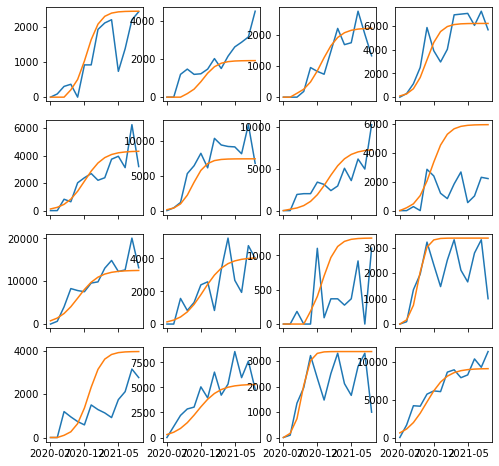

In [16]:
for i in range(len(models.keys())): 
    df = brandPredictions['brand_1'][i]
    dfTrue = transformedData['brand_1']
    columns = [c for c in dfTrue.columns if filterMonths(c)]
    plotRandomRegions(dfTrue[columns], df)
    break

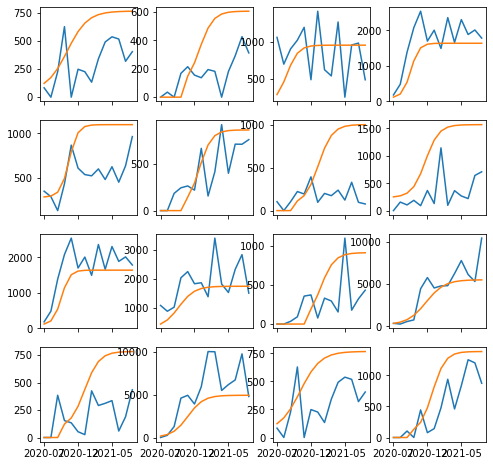

In [17]:
for i in range(len(models.keys())): 
    df = brandPredictions['brand_2'][i]
    dfTrue = transformedData['brand_2']
    columns = [c for c in dfTrue.columns if filterMonths(c)]
    plotRandomRegions(dfTrue[columns], df)
    break

In [34]:
# load test data
salesTest = pd.read_csv('./data/data_files/sales_test_splitted.csv', index_col=0)
testFeatures = {brand: pd.read_csv('./data/data_files/region_features/test_{}.csv'.format(brand), index_col=0) for brand in brands}
salesTest.shape, testFeatures['brand_1'].shape, testFeatures['brand_2'].shape

((3000, 4), (50, 25), (50, 18))

In [35]:
# predict entire test data with all models
predictions = {}
for brand in brands: 
    brandPredictions = {}
    for fold in range(len(cvSplit)): 
        model, scaler = models[str(fold)][brand], scalers[str(fold)][brand]
        currentFeatures = testFeatures[brand]
        xScaled = scaler.transform(currentFeatures.values)
        parameters = model.predict(xScaled)
        predictedSales = []
        for params in parameters: 
            salesForecasts = predictSales(monthsToPredict, *params)
            predictedSales.append(salesForecasts)
        predictedSales = pd.DataFrame(predictedSales, index=currentFeatures.index)
        brandPredictions[fold] = predictedSales
    predictions[brand] = brandPredictions

In [36]:
testCiBounds = {brand: getCiFromCv(predictions[brand]) for brand in brands}

In [37]:
# train model on entire trainings data and predict test data
predictions = {}
models, scalers = {}, {}
for brand in brands: 
    modelyTrue = linearModels[brand]
    currentFeatures = features[brand]
    
    scaler = StandardScaler()
    xTrainScaled = scaler.fit_transform(currentFeatures.values)
    xTestScaled = scaler.transform(testFeatures[brand].values)

    model = modelType(**modelParams)
    model.fit(xTrainScaled, modelyTrue)

    parameters = model.predict(xTestScaled)
    predictedSales = []
    for params in parameters: 
        salesForecasts = predictSales(monthsToPredict, *params)
        predictedSales.append(salesForecasts)
    predictedSales = pd.DataFrame(predictedSales, index=testFeatures[brand].index)
    
    models[brand] = model
    scalers[brand] = scaler
    predictions[brand] = predictedSales

In [38]:
for brand, df in predictions.items(): 
    df.rename(columns={c: monthColumns[c] for c in df.columns.values}, inplace=True)
    
for brand, bounds in testCiBounds.items(): 
    lower, upper = bounds
    lower.rename(columns={c: monthColumns[c] for c in lower.columns.values}, inplace=True)
    upper.rename(columns={c: monthColumns[c] for c in upper.columns.values}, inplace=True)

In [39]:
submissionData = getSubmissionDataFromSales(predictions, testCiBounds)

In [40]:
submissionData.shape

(1400, 6)

In [41]:
submissionData.head(n=25)

,month,region,brand,sales,lower,upper
0,2020-07,region_151,brand_1,0.000000,0.000000,0.000000
1,2020-07,region_151,brand_2,134.407183,110.993622,170.336709
2,2020-07,region_152,brand_1,0.000000,0.000000,0.000000
3,2020-07,region_152,brand_2,360.243964,327.100941,401.376590
4,2020-07,region_153,brand_1,0.000000,0.000000,0.000000
5,2020-07,region_153,brand_2,387.543445,341.102777,434.139320
6,2020-07,region_154,brand_1,2536.450793,2215.875856,2791.387954
7,2020-07,region_154,brand_2,397.793876,371.732826,435.854968
8,2020-07,region_155,brand_1,0.000000,0.000000,0.000000
9,2020-07,region_155,brand_2,0.000000,0.000000,21.821972


In [42]:
submissionData.to_csv('./data/data_files/submissions/sigmoid_ridge_default_regression.csv', 
                     index=False)

### Time-based prediction